# pyUserCalc

This is a python jupyter notebook that calculates uranium-series disequilibrium activity ratios in partial melts, for a 1D mantle decompression melting scenario. The notebook can determine U-series activities in partial melts for either of two end-member transport models.

One model option will determine melt compositions for a full equilibrium transport scenario (reactive porous flow) by recreating the functionality of Spiegelman's [UserCalc](http://www.ldeo.columbia.edu/~mspieg/UserCalc) website for calculating Uranium-series disequilibria for the equilbrium transport model described in:

    Spiegelman, M., 2000. UserCalc: A Web-based uranium series calculator for magma migration problems. Geochem. Geophys. Geosyst. 1, 1016. https://doi.org/10.1029/1999GC000030.

The other model determines melt compositions for a full disequilibrium transport scenario (i.e., there is no melt-rock reequilibration after melt generation, but aggregated melts are still transported along the length of the melt column), using the disequilibrium transport model described in the Appendix of Spiegelman, M. and Elliott T. (1993).

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Enter initial input information

In [4]:
# The user should set initial inputs by editing the code in this cell.

# Set the name for the input data file to be used in this model run.
# The name in quotes below should match the name of your input file,
# minus the file extension (.csv). You may download the sample file 
# to see the correct format for user input files. Your input file
# should be saved to the "data" folder prior to running this code.

runname='sample'

# Set the final melting pressure for this model run. This pressure will
# be used to impose a lithospheric cap that truncates the melt column
# and terminates the melting calculation. Note that any transport time after
# melting terminates is not automatically calculated by this model.

Plithos = 5.0  # kilobars

## An equilibrium decay chain solver class

This class solves the generic radiocative decay chain problem for the logarithm of the radiogenic component of melt concentration, after Equation 9 in Spiegelman (2000).

$$
    \frac{dU_i^r}{dz} = \lambda'_i\frac{\overline{\rho D_{i}}}{\overline{F D_{i}}}\left[ R_i^{i-1}\exp[U_{i-1}-U_i] - 1\right]
$$

where 
$$
    \lambda'_i = \frac{h\lambda_i}{W_0}
$$ 

are the decay constants scaled by the solid transport time ($h/W_0$) across a layer of depth $h$.

\begin{align}
    \overline{\rho D_{i}} &= \frac{\rho_f}{\rho_s}\phi + (1 -\phi)D_i\\
    \overline{F D_{i}} &= F + (1 -F)D_i
\end{align}

and

$$
    R_i^{i-1} = \alpha_i\frac{D_i^0}{D_{i-1}^0}\frac{\overline{\rho D_{i-1}}}{\overline{\rho D_{i}}}
$$

is the ingrowth factor. $\alpha$ is the initial degree of secular disequilibrium in the *unmelted solid*.

Note:  $U_i = \log(c_f/c_f^0)$ is the total log of the concentration of nuclide $i$ in the melt which can be decomposed into

$$
  U_i = U^s_i + U^r_i
$$

where

$$
    U^s_i = \log\left[ \frac{D_i^0}{\overline{FD}_i}\right]
$$

is the log concentration of a stable nuclide with the same partition coefficients.  U^r_i is the radiogenic ingrowth component.

In [5]:
# This is the equilibrium transport calculator. You probably will not need or want to edit this cell.
# A possible exception: the ODE solver method can be changed if desired, but the default is probably best.

from scipy.integrate import solve_ivp

class EquilTransport:
    '''
    A class for calculating generic radioactive decay chains for the scaled equations 9 in Spiegelman (2000)
    
    Usage:  solver=model(alpha0,lambdas,D,F,dFdz,phi,rho_f=2800.,rho_s=3300.,method='Radau')
    
    Inputs:
        alpha0  :  numpy array of initial activities
        lambdas :  decay constants scaled by solid transport time
        D       :  Function returning an array of partition coefficents at scaled height z'
        F       :  Function that returns the degree of melting F as a function of  z'
        dFdz    :  Function that returns the derivative of F with respect to z'
        phi     :  Function that returns the porosity phi as a function of z'
        rho_f   :  melt_density
        rho_s   :  solid_density
        method  :  ODE solver method to be passed to ode_solveivp (one of 'RK45', 'Radau', 'BDF')
        
    Outputs:  pandas DataFrame with columns z, Us, Uf
    '''      
    def __init__(self,alpha0,lambdas,D,F,dFdz,phi,rho_f=2800., rho_s=3300.,method='Radau'):
        self.alpha0 = alpha0
        self.N = len(alpha0)
        self.D = D
        self.D0 = np.array([D[i](0.) for i in range(self.N)])
        self.lambdas = lambdas
        self.F  = F
        self.dFdz = dFdz
        self.phi = phi
        self.rho_f = rho_f
        self.rho_s = rho_s
        self.method = method
    
    def F_bar(self,zp):
        '''
        returns  numpy array of  size (len(zp),len(D)) for
        
        Fbar_D = F + (1. - F)*D_i
        '''
        D = self.D
        F = self.F(zp)
        if np.isscalar(zp):
            F_bar_D = np.array([ F + (1. - F)*D[i](zp) for i in range(len(D))])
        else :
            F_bar_D = np.zeros((len(zp),len(D)))
            F_bar_D = np.array([ F + (1. - F)*D[i](zp) for i in range(len(D))]).T
        return F_bar_D
    
    def rho_bar(self,zp):
        '''
        returns numpy array of  size (len(zp),len(D)) for
        
        rho_bar_D = rho_f/rho_s*phi + (1. - phi)*D_i
        '''
        rho_s = self.rho_s
        rho_f = self.rho_f
        
        phi = self.phi(zp)
        D = self.D
        if np.isscalar(zp):
            rho_bar_D = np.array([ rho_f/rho_s*phi + (1. - phi)*D[i](zp) for i in range(len(D))])
        else: 
            rho_bar_D = np.zeros((len(zp),len(D)))
            rho_bar_D = np.array([ rho_f/rho_s*phi + (1. - phi)*D[i](zp) for i in range(len(D))]).T
           
        return rho_bar_D
    
    def rhs(self,z,Ur):
        '''
        Returns right hand side of generic decay chain problem for the log of the radiogenic concentration.
        
        The full equation for dU/dz is given by Eq (9) in Spiegelman 2000, but here we split
        
        Uf = U^st + U^r where
        U^st is the log of the stable element concentrations U^s = log(D(0)/Fbar_z)
        U^r is the radiogenic ingrowth part
        
        Solid concentration is ignored as unnecessary in this version, but would be simply the fluid
        concentration times the partition coefficient for that depth.
        
        The general equation is 
            dU_i^r/dz = h\lambda_i/Weff_i * [ R_i^{i-1} exp(Uf_{i-1} - Uf_i) - 1.)
            
        This routine assumes that lambda, D, D0, lambda_tmp, phi0, W_0 and alpha_0 are set by the UserCalc driver routine.
        '''
            
        # determine F_bar(z) and rho_bar(z) once
        Fb = self.F_bar(z)
        rb = self.rho_bar(z)
        
        # initial value of partition coefficients
        D0 = self.D0
        
        # initial value densities
        rho_f = self.rho_f
        rho_s = self.rho_s
        
        # stable concentration
        Ust = np.log(D0/Fb)
        
        # total melt concentration
        Uf = Ust + Ur

        # effective velocity and scaled rate term
        lambda_prime = self.lambdas*rb/Fb
        
        # ingrowth factor and exponential factor
        R = np.zeros(len(lambda_prime))
        expU = np.zeros(len(lambda_prime))
        for i in range(1,len(lambda_prime)):
            R[i] = self.alpha0[i]*D0[i]/D0[i-1]*rb[i-1]/rb[i]
            expU[i] = np.exp(Uf[i-1]-Uf[i])
            
        # return full RHS
        
        return lambda_prime*(R*expU - 1.)
        
    def solve(self,z_eval=None):
        '''
        solves generic radioactive decay chain problem as an ODE initial value problem
        if z_eval = None, save every point
        else save output at every z_eval depth
        '''
        
        # Set initial condition and solve ODE      
        Ur_0 = np.zeros(len(self.D0))
        sol = solve_ivp(self.rhs,(0.,1.),Ur_0,t_eval=z_eval,method=self.method)
        z = sol.t
        Ur = sol.y
        # calculate stable component of fluid concentration
        Ust = np.log(self.D0/self.F_bar(z)).T 
        # calculate total fluid concentration
        Uf = Ur + Ust
        # placeholder for solid concentration (not used here, but cannot be blank)
        Us = Uf
        return z,Us,Uf
        
        

## A disequilibrium decay chain solver class

This class solves the disequilibrium transport problem described in Spiegelman and Elliott, 1993, i.e., Eqs. (26) and (27) rewritten in terms of the logs of the concentrations:

$$
    U^s_i = \log\left(\frac{c_i^{s}}{c_{i,0}^s}\right),  \quad U^f_i = \log\left(\frac{c_i^{f}}{c_{i,0}^f}\right) 
$$
thus
$$
    \frac{dU_i}{dz} = \frac{1}{c_i} \frac{dc_i}{dz}
$$

In [6]:
# This is the equilibrium transport calculator. You probably will not need or want to edit this cell.
# A possible exception: the ODE solver method can be changed if desired, but the default is probably best.

from scipy.integrate import solve_ivp

class DisequilTransport:
    '''
    A class for calculating generic radioactive decay chains for the scaled equations 9 in Spiegelman (2000)
    
    Usage:  solver=model(alpha0,lambdas,D,F,dFdz,phi,rho_f=2800., rho_s=3300.,method='Radau')
    
    inputs:
        alpha0  :  numpy array of initial activities
        lambdas :  decay constants scaled by solid transport time
        D       :  Function returning an array of partition coefficents at scaled height z'
        F       :  Function that returns the degree of melting F as a function of  z'
        dFdz    :  Function that returns the derivative of F with respect to z'
        phi     :  Function that returns the porosity phi as a function of z'
        rho_f   :  melt_density
        rho_s   :  solid_density
        method  :  ODE solver method to be passed to ode_solveivp (one of 'RK45', 'Radau', 'BDF')
        
    Outputs:  pandas DataFrame with columns z, Us, Uf
    '''
    def __init__(self,alpha0,lambdas,D,F,dFdz,phi,rho_f=2800.,rho_s=3300.,method='Radau'):
        self.alpha0 = alpha0
        self.N = len(alpha0)
        self.D = lambda zp: np.array([D[i](zp) for i in range(self.N) ])
        self.D0 = self.D(0.)
        self.lambdas = lambdas
        self.F  = F
        self.dFdz = dFdz
        self.phi = phi
        self.rho_f = rho_f
        self.rho_s = rho_s
        self.method = method
        
    def rhs(self,z,U):
        '''
        Returns right hand side of generic chain problem for the log of concentration of the solid
        U^s = U[:N]  where N=length of the decay chain
        and
        U^f = U[N:]
        
        The full equation for dU/dz is given by Eqs 28 and 29 in Spiegelman and Elliott (1993), but
        in terms of concentrations c^s and c^f. Here log concentrations are calculated as in Spiegelman (2000).
            
        This routine assumes that lambda, D, D0, lambda_tmp, phi0, W_0 and alpha_0 are set by the UserCalc driver routine.
        '''
        
        # calculate F(z) and D(z)
        F = self.F(z)
        dFdz = self.dFdz(z)
        D = np.array(self.D(z))
        phi = self.phi(z)
        
        # initial value of partition coefficients
        D0 = self.D0
        
        # split U into solid and melt components for convenience
        N = self.N
        Us = U[:N]
        Uf = U[N:]
        
        # stable melting component of dU
        dUs = (1. - 1./D)/(1.-F)*dFdz
        # careful here about the initial gradient (and floating point test)
        if F == 0.:
            dUf = dUs/2.
        else:
            dUf = (D0/D*np.exp(Us - Uf) -1.)/F
            
        # ingrowth terms
        Rs = np.zeros(N)
        Rf = np.zeros( N)
        a0 = self.alpha0
        for i in range(1,N):
            Rs[i] = a0[i-1]/a0[i]*np.exp(Us[i-1]-Us[i])
            Rf[i] = (D0[i]*a0[i-1])/(D0[i-1]*a0[i])*np.exp(Uf[i-1]- Uf[i])
            
        # add to stable terms
        dUs += (1 - phi)/(1. - F)*self.lambdas*(Rs - 1.)
        if F == 0.:
            dUf +=  self.lambdas*(Rf - 1.)
        else:
            dUf += (self.rho_f*phi)/(self.rho_s*F)*self.lambdas*(Rf - 1.)
            
        # return full RHS
        dU=np.zeros(2*N)
        dU[:N] = dUs
        dU[N:] = dUf
        
        return dU
        
    def solve(self,z_eval=None):
        '''
        solves generic radioactive decay chain problem as an ODE initial value problem
        if z_eval = None,  save every point
        else save output at every z_eval depth
        '''
        
        # Set initial condition and solve ODE  
        N = self.N
        U0 = np.zeros(2*N)
        try:
            sol = solve_ivp(self.rhs,(0.,1.),U0,t_eval=z_eval,method=self.method)
            z = sol.t
            U = sol.y
        except ValueError as err:
            print('Warning:  solver did not complete, returning NaN: {}'.format(err))
            z = np.array([1.])
            U = np.NaN*np.ones((2*N,len(z)))
        # return solid and liquid concentrations
        Us = U[:N,:]
        Uf = U[N:,:]
        return z,Us,Uf
        

## Look at input data

In [7]:
input_file = 'input_files/{}.csv'.format(runname)
df = pd.read_csv(input_file,skiprows=1,dtype=float)
df = df[df.P > Plithos]

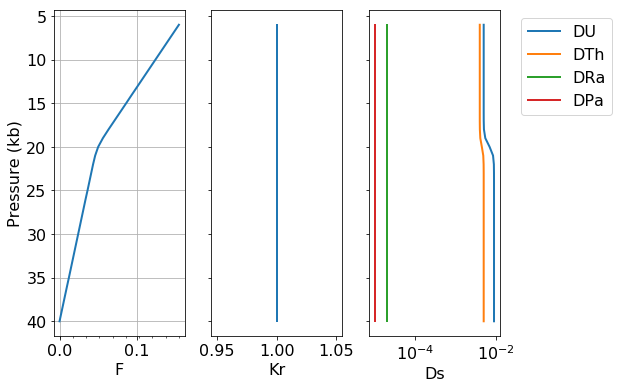

In [8]:
from UserCalc import plot_inputs
plot_inputs(df)

In [9]:
df

,P,F,Kr,DU,DTh,DRa,DPa
0,40.0,0.00000,1.0,0.00900,0.00500,0.00002,0.00001
1,39.0,0.00241,1.0,0.00900,0.00500,0.00002,0.00001
2,38.0,0.00482,1.0,0.00900,0.00500,0.00002,0.00001
3,37.0,0.00723,1.0,0.00900,0.00500,0.00002,0.00001
4,36.0,0.00964,1.0,0.00900,0.00500,0.00002,0.00001
5,35.0,0.01210,1.0,0.00900,0.00500,0.00002,0.00001
6,34.0,0.01450,1.0,0.00900,0.00500,0.00002,0.00001
7,33.0,0.01690,1.0,0.00900,0.00500,0.00002,0.00001
8,32.0,0.01930,1.0,0.00900,0.00500,0.00002,0.00001
9,31.0,0.02170,1.0,0.00900,0.00500,0.00002,0.00001


### Solve the 1-D column problem

In [10]:
# Initialize the solver object

# Choose and activate the model desired in the row below. The 'EquilTransport' does a full equilibrium
# (i.e., reactive porous flow) calculation, while 'DisequilTransport' determines full disequilibrium.

from UserCalc import UserCalc
us = UserCalc(EquilTransport,df)
#us = UserCalc(DisequilTransport,df)


# Set desired parameters for initial model run. Note that if nothing is entered here, the model default assumes
# phi0 = 0.008, W0 = 3 cm/yr., n = 2, rho_f = 2800, and rho_s = 3300.

phi0 = 0.008
W0 = 3. # cm/yr.
n = 2.
rho_f = 2800.
rho_s = 3300.

df_out = us.solve_all_1D(phi0,n,W0)

## Activities at the top of the column

In [11]:
df_out[['(230Th/238U)','(226Ra/230Th)','(231Pa/235U)']].iloc[-1]

(230Th/238U)     1.174901
(226Ra/230Th)    1.590379
(231Pa/235U)     2.094613
Name: 34, dtype: float64

In [12]:
df_out

,P,z,F,phi,(230Th/238U),(226Ra/230Th),(231Pa/235U),Uf_238U,Uf_230Th,Uf_226Ra,Us_238U,Us_230Th,Us_226Ra,Uf_235U,Uf_231Pa,Us_235U,Us_231Pa
0,40.0,123.559757,0.00000,0.000000,1.800000,250.000000,900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,39.0,120.470763,0.00241,0.000850,1.588834,7.582119,8.247231,-0.235378,-0.360164,-3.855832,-0.235378,-0.360164,-3.855832,-0.235457,-4.927974,-0.235457,-4.927974
2,38.0,117.381769,0.00482,0.001266,1.528899,5.501186,6.629682,-0.425776,-0.589015,-4.405512,-0.425776,-0.589015,-4.405512,-0.425923,-5.336761,-0.425923,-5.336761
3,37.0,114.292775,0.00723,0.001587,1.507399,4.618036,6.011252,-0.585658,-0.763059,-4.754551,-0.585658,-0.763059,-4.754551,-0.585863,-5.594625,-0.585863,-5.594625
4,36.0,111.203781,0.00964,0.001859,1.498016,4.104020,5.634433,-0.723468,-0.907113,-5.016607,-0.723468,-0.907113,-5.016607,-0.723725,-5.797223,-0.723725,-5.797223
5,35.0,108.114787,0.01210,0.002103,1.492196,3.751944,5.346096,-0.846931,-1.034468,-5.233655,-0.846931,-1.034468,-5.233655,-0.847234,-5.973262,-0.847234,-5.973262
6,34.0,105.025793,0.01450,0.002318,1.489116,3.500600,5.124922,-0.954272,-1.143875,-5.412402,-0.954272,-1.143875,-5.412402,-0.954617,-6.122896,-0.954617,-6.122896
7,33.0,101.936799,0.01690,0.002517,1.486413,3.307228,4.935146,-1.051200,-1.242621,-5.567971,-1.051200,-1.242621,-5.567971,-1.051584,-6.257596,-1.051584,-6.257596
8,32.0,98.847805,0.01930,0.002702,1.483849,3.151912,4.769181,-1.139559,-1.332706,-5.706158,-1.139559,-1.332706,-5.706158,-1.139978,-6.380198,-1.139978,-6.380198
9,31.0,95.758811,0.02170,0.002875,1.481161,3.023688,4.620566,-1.220741,-1.415701,-5.830685,-1.220741,-1.415701,-5.830685,-1.221193,-6.493070,-1.221193,-6.493070


## Plot solution with depth

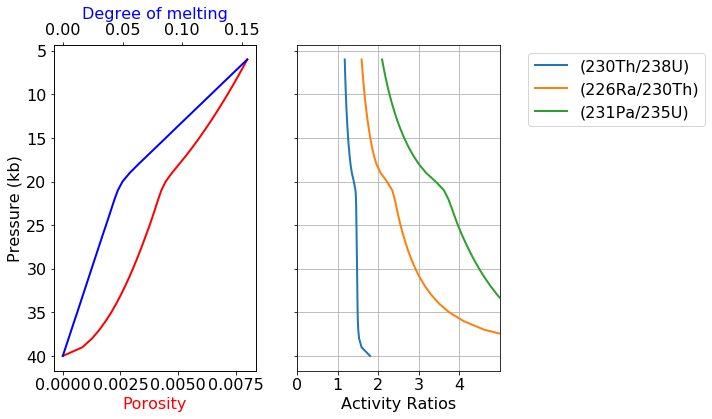

In [13]:
from UserCalc import plot_1Dcolumn
plot_1Dcolumn(df_out)
plt.show()

## View the dataframe

In [14]:
df_out

,P,z,F,phi,(230Th/238U),(226Ra/230Th),(231Pa/235U),Uf_238U,Uf_230Th,Uf_226Ra,Us_238U,Us_230Th,Us_226Ra,Uf_235U,Uf_231Pa,Us_235U,Us_231Pa
0,40.0,123.559757,0.00000,0.000000,1.800000,250.000000,900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,39.0,120.470763,0.00241,0.000850,1.588834,7.582119,8.247231,-0.235378,-0.360164,-3.855832,-0.235378,-0.360164,-3.855832,-0.235457,-4.927974,-0.235457,-4.927974
2,38.0,117.381769,0.00482,0.001266,1.528899,5.501186,6.629682,-0.425776,-0.589015,-4.405512,-0.425776,-0.589015,-4.405512,-0.425923,-5.336761,-0.425923,-5.336761
3,37.0,114.292775,0.00723,0.001587,1.507399,4.618036,6.011252,-0.585658,-0.763059,-4.754551,-0.585658,-0.763059,-4.754551,-0.585863,-5.594625,-0.585863,-5.594625
4,36.0,111.203781,0.00964,0.001859,1.498016,4.104020,5.634433,-0.723468,-0.907113,-5.016607,-0.723468,-0.907113,-5.016607,-0.723725,-5.797223,-0.723725,-5.797223
5,35.0,108.114787,0.01210,0.002103,1.492196,3.751944,5.346096,-0.846931,-1.034468,-5.233655,-0.846931,-1.034468,-5.233655,-0.847234,-5.973262,-0.847234,-5.973262
6,34.0,105.025793,0.01450,0.002318,1.489116,3.500600,5.124922,-0.954272,-1.143875,-5.412402,-0.954272,-1.143875,-5.412402,-0.954617,-6.122896,-0.954617,-6.122896
7,33.0,101.936799,0.01690,0.002517,1.486413,3.307228,4.935146,-1.051200,-1.242621,-5.567971,-1.051200,-1.242621,-5.567971,-1.051584,-6.257596,-1.051584,-6.257596
8,32.0,98.847805,0.01930,0.002702,1.483849,3.151912,4.769181,-1.139559,-1.332706,-5.706158,-1.139559,-1.332706,-5.706158,-1.139978,-6.380198,-1.139978,-6.380198
9,31.0,95.758811,0.02170,0.002875,1.481161,3.023688,4.620566,-1.220741,-1.415701,-5.830685,-1.220741,-1.415701,-5.830685,-1.221193,-6.493070,-1.221193,-6.493070


### Save the dataframe as a csv file

In [31]:
#filename='sample_out.csv'
df_out.to_csv("output_files/{}_1D_solution.csv".format(runname))

## Calculated gridded activity ratios at the top of the column

In [17]:
# Activate and edit the rows below to set phi and W values at evenly spaced log grid intervals:

# phi0 = np.logspace(-3,-2,11)
# W0 = np.logspace(-1,1,11)

# Activate and edit the rows below to set specific desired phi and W values for the grid:
phi0 = np.array([0.001, 0.002, 0.005, 0.01])
W0 = np.array([0.5, 1., 2., 5., 10., 20., 50.])  # cm/yr.

import time
tic = time.clock()
toc = time.clock()
print('\nelapsed time={}'.format(toc-tic))

# Calculate the U-238 decay chain activity ratios for final melts generated at all points in W vs. phi grid space:
act = us.solve_grid(phi0, n, W0, us.D_238, us.lambdas_238 )


elapsed time=2.6000000000081513e-05

W = 0.5 . . . . 
W = 1.0 . . . . 
W = 2.0 . . . . 
W = 5.0 . . . . 
W = 10.0 . . . . 
W = 20.0 . . . . 
W = 50.0 . . . . 

In [18]:
# Save the U-238 decay chain grid results as .csv files.

Th = act[0]
Ra = act[1]

df = pd.DataFrame(Th)
df.to_csv("output_files/{}_Th_grid.csv".format(runname))
df = pd.DataFrame(Ra)
df.to_csv("output_files/{}_Ra_grid.csv".format(runname))

In [20]:
# Calculate the U-235 decay chain activity ratios for final melts generated at all points in W vs. phi grid space:
act_235 = us.solve_grid(phi0, n, W0, us.D_235, us.lambdas_235 )
Pa = act_235[0]

# Save the U-235 decay chain grid results as a .csv file.
df = pd.DataFrame(Pa)
df.to_csv("output_files/{}_Pa_grid.csv".format(runname))


W = 0.5 . . . . 
W = 1.0 . . . . 
W = 2.0 . . . . 
W = 5.0 . . . . 
W = 10.0 . . . . 
W = 20.0 . . . . 
W = 50.0 . . . . 

## Plot gridded decay results using W vs. phi contour plots

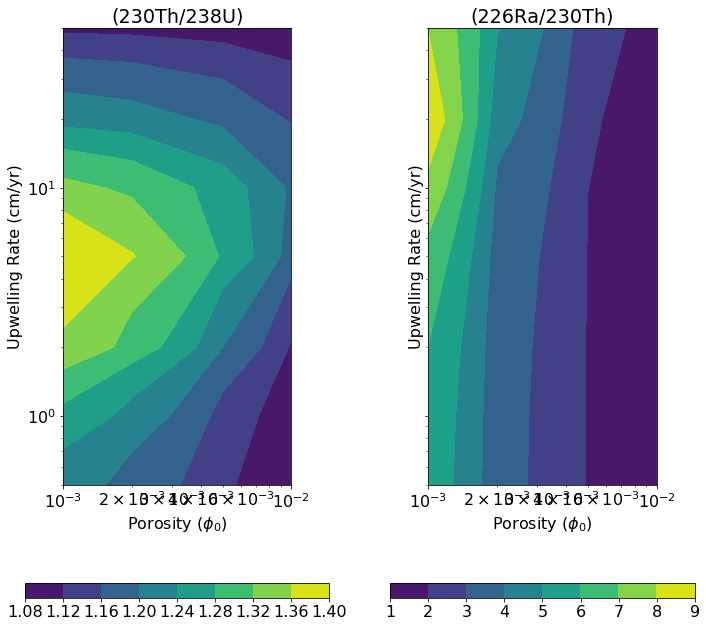

In [25]:
from UserCalc import plot_contours
plot_contours(phi0,W0,act,figsize=(12,12))
plt.savefig("output_files/{}_Th_Ra_contours.ps".format(runname))

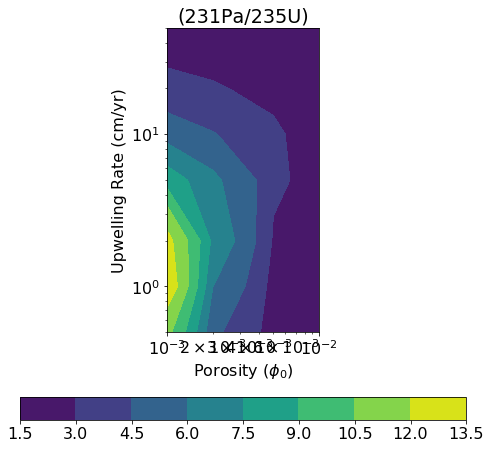

In [26]:
plot_contours(phi0,W0,act_235,figsize=(8,8))
plt.savefig("output_files/{}_Pa_contours.ps".format(runname))

## Plot gridded decay results using activity ratio-activity ratio plots

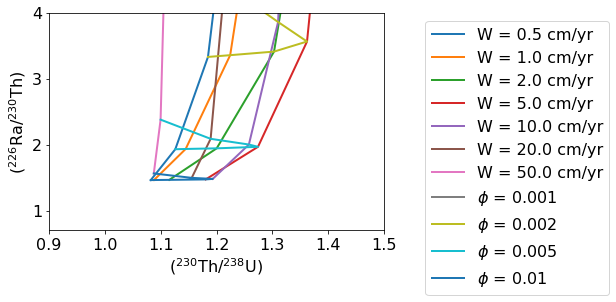

In [27]:
from UserCalc import plot_mesh_Ra
plot_mesh_Ra(Th,Ra,W0,phi0)
plt.savefig("output_files/{}_Ra-Th.ps".format(runname))

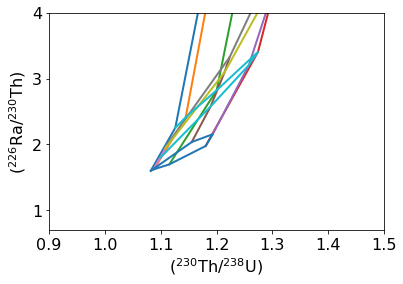

<Figure size 432x288 with 0 Axes>

In [29]:
from UserCalc import plot_mesh_Pa
plot_mesh_Pa(Th,Pa,W0,phi0)
plt.savefig("output_files/{}_Pa-Th.ps".format(runname))